# Title

This Notebook...

## Initialization

### Imports

In [2]:
import numpy
import matplotlib.pyplot

import sys
sys.path.append("../")
import congestionfinder
import congestionfinder.bpsdetector
import congestionfinder.road
import congestionfinder.detection
import congestionfinder.speedflow
import congestionfinder.congestion
import congestionfinder.boundaryscanner

## Classes

In [3]:
bpsDetector = congestionfinder.bpsdetector.BPSDetector("00D00C03405B18200005")
print(bpsDetector)

bpsCode: 00D00C03405B18200005 | roadNumber: 12 | hectometer: 208 | additionalMeters: 91


In [4]:
road = congestionfinder.road.Road(12)
road.addBPSDetector(bpsDetector)
print(road)
road.indexDetectorSpaces()
print(road.getSpaceToSpaceIndex())

roadNumber: 12 | len(bpsDetectors): 1 | len(spaceToSpaceIndex): 0
{20891: 0}


In [5]:
detection = congestionfinder.detection.Detection("00D00C03405B18200005", 1234, 1440, 120, 17)
print(detection)

code: 00D00C03405B18200005 | space: 1234 | time: 1440 | speed: 120 | flow: 17


## Roads

In [24]:
roads = congestionfinder.road.parseBPSCodesToRoads(["10D00204D037D007000B", "10D002051800D0070013", "10D002057000D007000F"])
for value in roads.values():
    value.indexDetectorSpaces

In [25]:
for value in sorted(roads.values(), key = lambda x:len(x.getBPSDetectors())):
    print(value)

roadNumber: 2 | len(bpsDetectors): 3 | len(spaceToSpaceIndex): 3


## Speed and Flows

In [40]:
detections = []
detections.append(congestionfinder.detection.Detection("10D00204D037D007000B", 30855, 1, 80, 17))
detections.append(congestionfinder.detection.Detection("10D00204D037D007000B", 30855, 2, 70, 16))
detections.append(congestionfinder.detection.Detection("10D00204D037D007000B", 30855, 3, 75, 17))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 1, 40, 10))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 2, 55, 18))
detections.append(congestionfinder.detection.Detection("10D002051800D0070013", 32600, 3, 35, 12))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 1, 70, 19))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 2, 85, 14))
detections.append(congestionfinder.detection.Detection("10D002057000D007000F", 34800, 3, 100, 19))

In [41]:
speeds, flows, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex = congestionfinder.speedflow.parseDetectionsToSpeedsAndFlows(detections, roads[2])

(3, 3)
(3, 3)
0
2
1
3


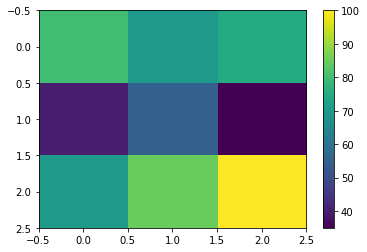

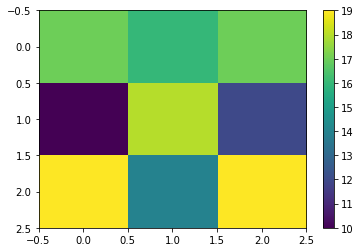

In [44]:
print(speeds.shape)
print(flows.shape)
print(minSpaceIndex)
print(maxSpaceIndex)
print(minTimeIndex)
print(maxTimeIndex)
matplotlib.pyplot.imshow(speeds, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flows, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [45]:
speedsHighFlow, flowsHighFlow, maskHighFlow = congestionfinder.speedflow.removeLowFlowTimes(speeds, flows) ## Do something with Mask

(3, 3)
(3, 3)
1.0


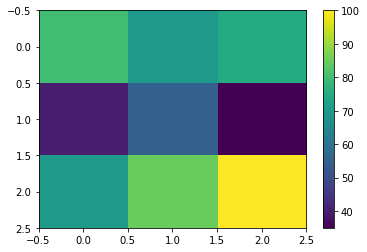

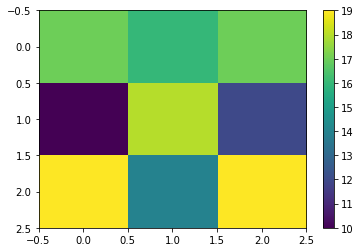

In [46]:
print(speedsHighFlow.shape)
print(flowsHighFlow.shape)
print(sum(maskHighFlow) / (sum(maskHighFlow) + sum(~maskHighFlow)))
matplotlib.pyplot.imshow(speedsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsHighFlow, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [47]:
speedsWorkingDetectors, flowsWorkingDetectors, maskWorkingDetectors = congestionfinder.speedflow.removeMissingDetectors(speeds, flows) ## Do something with Mask

(3, 3)
(3, 3)
1.0


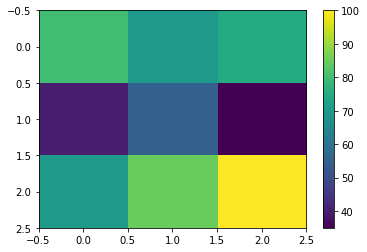

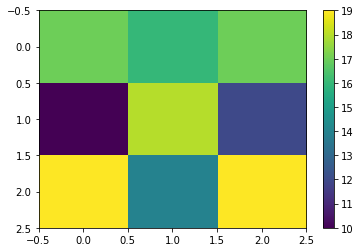

In [48]:
print(speedsWorkingDetectors.shape)
print(flowsWorkingDetectors.shape)
print(sum(maskWorkingDetectors) / (sum(maskWorkingDetectors) + sum(~maskWorkingDetectors)))
matplotlib.pyplot.imshow(speedsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(flowsWorkingDetectors, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

## Congestion

In [49]:
congestions = congestionfinder.congestion.parseSpeedFlowsToCongestions(speedsWorkingDetectors, flowsWorkingDetectors)

(3, 3)


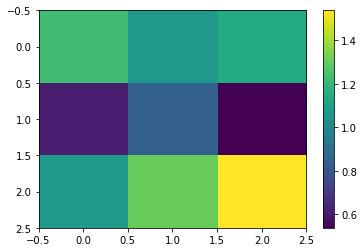

In [50]:
print(congestions.shape)
matplotlib.pyplot.imshow(congestions, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [51]:
congestionsWithoutMissingValues = congestionfinder.congestion.interpolateMissingValues(congestions)

(3, 3)


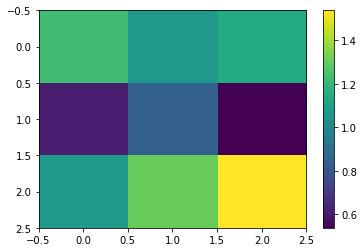

In [52]:
print(congestionsWithoutMissingValues.shape)
matplotlib.pyplot.imshow(congestionsWithoutMissingValues, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [53]:
congestionsSmoothed = congestionfinder.congestion.applySmoothingFilter(congestionsWithoutMissingValues)

(3, 3)


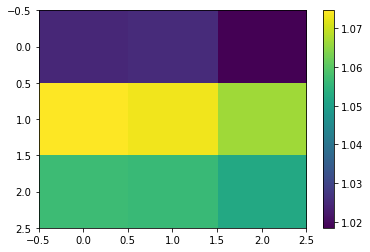

In [54]:
print(congestionsSmoothed.shape)
matplotlib.pyplot.imshow(congestionsSmoothed, aspect = "auto")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

## Congestion Filter

In [55]:
testDataArray = numpy.random.rand(16,9)
print(testDataArray >= 0.9)

[[False  True False False False False False False False]
 [False  True False False False False False  True False]
 [False False False  True False  True False False  True]
 [False False False False  True False False False False]
 [False False False  True False False False  True False]
 [False False False False False False False False False]
 [False False False False False  True False False False]
 [False False False False False False False False False]
 [False  True  True False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [ True False False False False False False False False]
 [False False False False False False  True False False]
 [ True False False False False False False False  True]
 [False False False False False False False  True  True]
 [False False  True False  True False False False False]]


In [56]:
congestionfinder.boundaryscanner.scanForBoundaries(testDataArray, threshold = 0.1, depth = 0)

[[0, 15, 0, 0], [0, 15, 2, 8]]

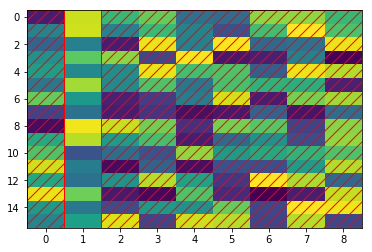

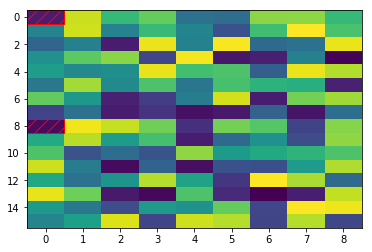

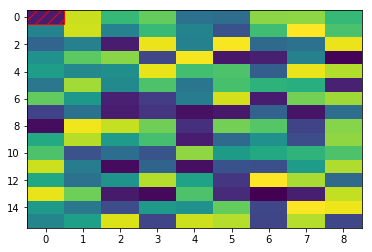

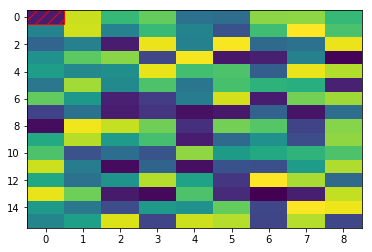

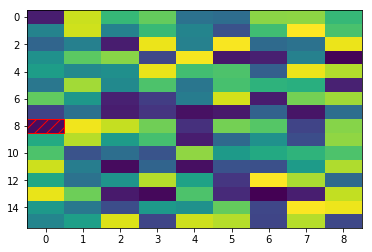

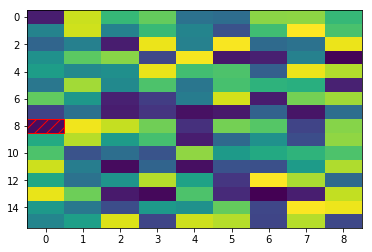

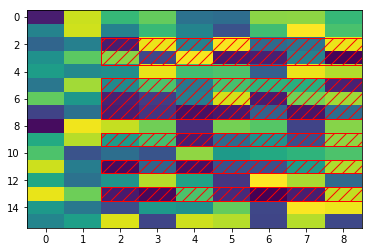

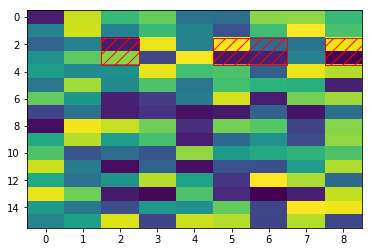

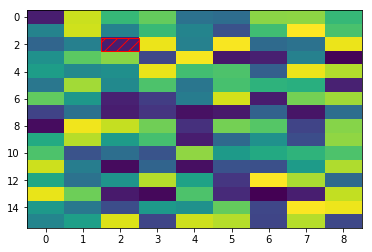

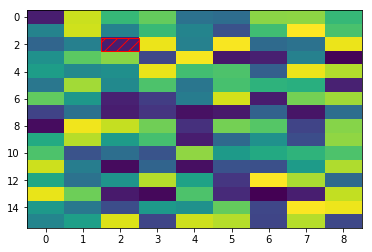

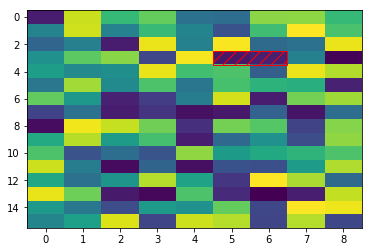

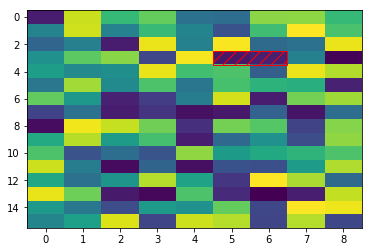

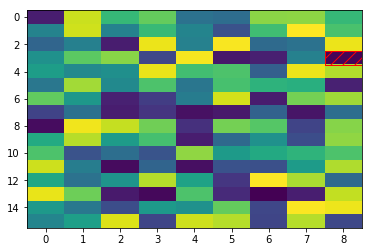

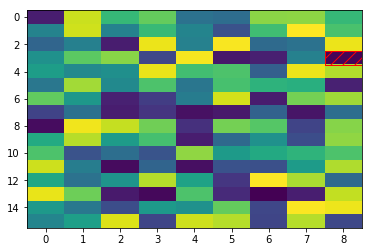

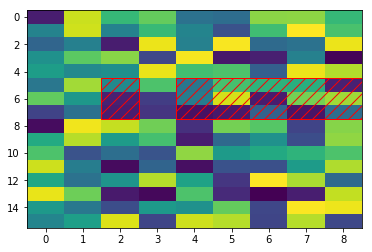

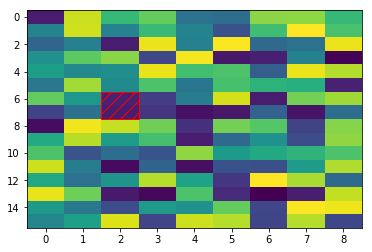

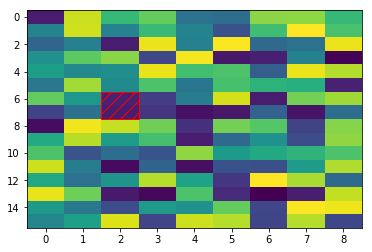

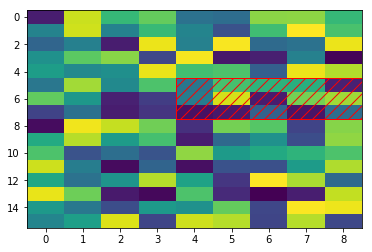

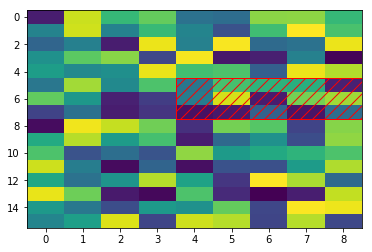

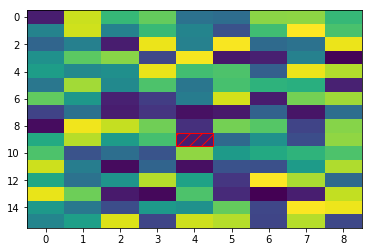

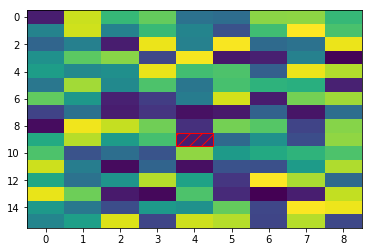

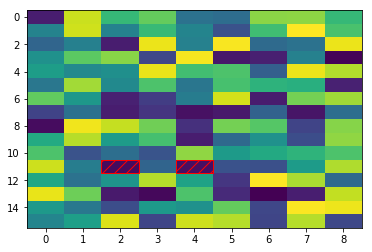

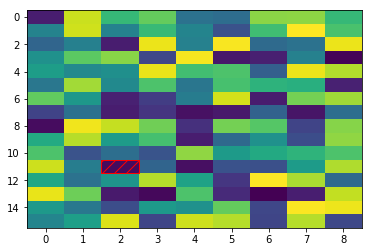

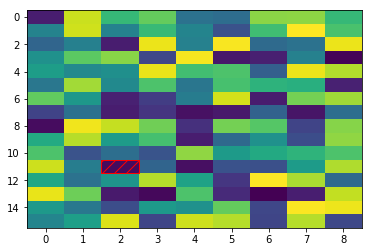

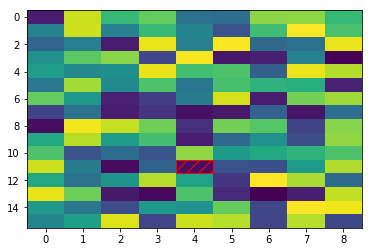

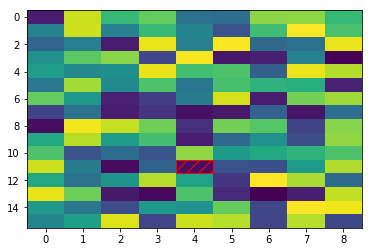

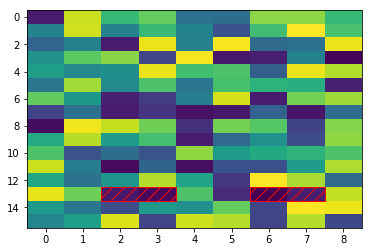

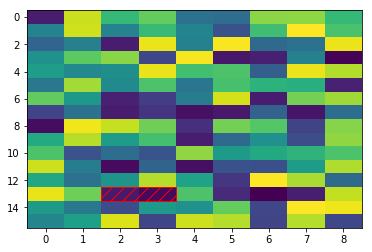

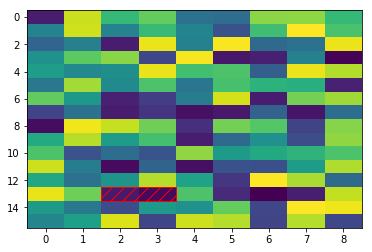

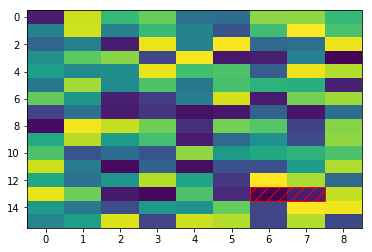

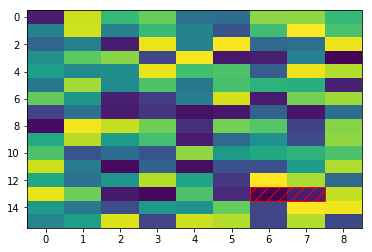

In [57]:
testBoundariesList = congestionfinder.boundaryscanner.recursiveScanForBoundaries(testDataArray, threshold = 0.1)

In [58]:
testBoundariesList

[[0, 0, 0, 0],
 [8, 8, 0, 0],
 [2, 2, 2, 2],
 [3, 3, 5, 6],
 [3, 3, 8, 8],
 [6, 7, 2, 2],
 [5, 7, 4, 8],
 [9, 9, 4, 4],
 [11, 11, 2, 2],
 [11, 11, 4, 4],
 [13, 13, 2, 3],
 [13, 13, 6, 7]]

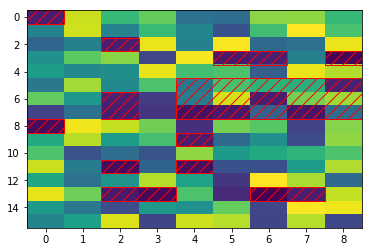

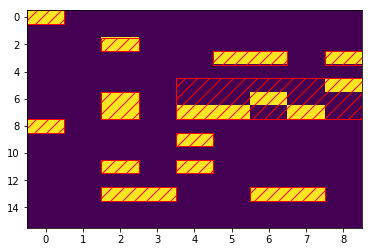

In [59]:
congestionfinder.boundaryscanner.plotCongestionsWithBoundaries(testDataArray, testBoundariesList)
congestionfinder.boundaryscanner.plotCongestionsWithBoundaries(testDataArray < 0.1, testBoundariesList)

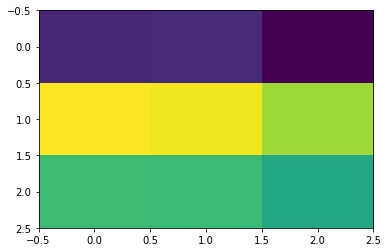

In [60]:
congestionBoundariesList = congestionfinder.boundaryscanner.recursiveScanForBoundaries(congestionsSmoothed)

In [61]:
print(congestionBoundariesList)

[]


In [62]:
congestionBoundariesListFiltered = congestionfinder.boundaryscanner.filterLargeCongestions(congestionBoundariesList)

In [63]:
print(congestionBoundariesListFiltered)

[]


In [64]:
congestionBoundariesListWithMargins = congestionfinder.boundaryscanner.addMargins(congestionBoundariesListFiltered, minSpaceIndex, maxSpaceIndex, minTimeIndex, maxTimeIndex)

In [65]:
print(congestionBoundariesListWithMargins)

[]


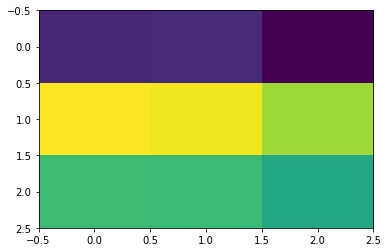

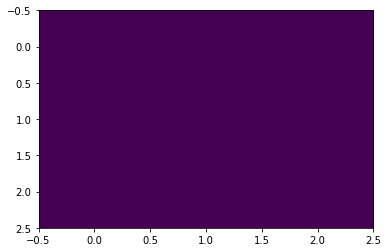

In [66]:
congestionfinder.boundaryscanner.plotCongestionsWithBoundaries(congestionsSmoothed, congestionBoundariesListWithMargins)
congestionfinder.boundaryscanner.plotCongestionsWithBoundaries(congestionsSmoothed < 1, congestionBoundariesList)

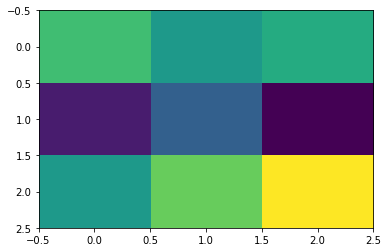

In [67]:
congestionfinder.boundaryscanner.plotCongestionsWithBoundaries(speeds, congestionBoundariesListWithMargins)

End of Notebook